In [1]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module
import scanpy as sc

import pandas as pd
import numpy as np
import plotly.express as px

import os
import pprint 
import plotly
import matplotlib.pyplot as plt 

%matplotlib inline


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
!ls {data_path}

1qc.h5ad
adj.csv
annotated.h5ad
annotated_with_cnvs.h5ad
annotated_with_cnvs_old.h5ad
combined.loom
copykat_result_copykat_CNA_raw_results_gene_by_cell.txt
copykat_result_copykat_CNA_results.txt
copykat_result_copykat_prediction.txt
copykat_result_copykat_with_genes_heatmap.pdf
deg
filtered.loom
fin_object.celloracle.oracle
for_scpubr_plot.h5ad
integrated.h5ad
links.celloracle.links
model.model
obj.celloracle.oracle
reg.csv
scenic_out.loom
tumor_for_deg.h5ad
tumor_only.h5ad
tumor_with_OPC_COP.h5ad
velocity.h5ad


In [ ]:
# select highly variable genes
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))
adata

In [ ]:
# select highly variable genes for cell oracle
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor= 'seurat_v3', layer = 'counts', batch_key='sample_id')

#### 1. Calculate pseudotime


In [ ]:
pt = Pseudotime_calculator(adata=adata, obsm_key = 'X_umap', cluster_column_name='cell_type')

In [ ]:
adata.obs.cell_type.nunique()

In [ ]:
lineage_dictionary = {
    "Oligo" : ["NSC", "OPC", "COP", "Oligodendrocyte"],
    "Tumor" : ["OPC", "COP", "Tumor"],
    "Neuron" : ["NSC", "Neuron"],
    "Astrocyte" : ["NSC", "Astrocyte"], # GPC,
    "Others" : ["Endothelial_cell", "Pericyte", "Ependymal_cell"],
    "Immune" : ["Microglia", "T-cell"],
}

In [ ]:
pt.set_lineage(lineage_dictionary=lineage_dictionary)

In [ ]:
def plot(adata, embedding_key, cluster_column_name):
    embedding = adata.obsm[embedding_key]
    df = pd.DataFrame(embedding, columns=["x", "y"])
    df["cluster"] = adata.obs[cluster_column_name].values
    df["label"] = adata.obs.index.values
    fig = px.scatter(df, x="x", y="y", hover_name=df["label"], color="cluster")
    fig.show()

plot(adata=pt.adata,
        embedding_key=pt.obsm_key,
        cluster_column_name=pt.cluster_column_name)

In [ ]:
cond = adata.obs.cell_type == 'OPC'
ax = sc.pl.umap(adata, palette = 'lightgrey', show = False)
sc.pl.umap(adata[cond], color = "cell_type", ax = ax, legend_loc = None, s=5, palette = 'k')

In [ ]:
root_cells = {'Oligo': "CCTTCAGTCCATTCAT-1",
    'Tumor': "GCATTAGGTCCGGCAT-1", #"GCGATCGCATCCAATG-1",
    'Neuron': "CTAGGTATCGACCACG-1",
    'Astrocyte': "ATTCACTAGTCGTCTA-1",
    'Others': "CCCTCTCGTCGCATCG-1", # 대충
    'Immune': "GCTTGGGTCGAACACT-1", # 대충
}
pt.set_root_cells(root_cells=root_cells)

In [ ]:
pt.plot_root_cells()

In [ ]:
# calculae diffusion map
sc.tl.diffmap(pt.adata)

In [ ]:
pt.get_pseudotime_per_each_lineage()
pt.plot_pseudotime(cmap = 'rainbow')

#### 2. Calculate GRN

In [ ]:
oracle = co.Oracle()

In [ ]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

In [ ]:
adata.X = adata.layers['counts'].copy()
oracle.import_anndata_as_raw_count(adata = adata, cluster_column_name='cell_type', embedding_name='X_umap')

In [ ]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [ ]:
oracle.perform_PCA()

In [ ]:
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

In [ ]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)
oracle.to_hdf5(os.path.join(data_path, "obj.celloracle.oracle"))

In [ ]:
links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10,
                         verbose_level=10)
links.to_hdf5(file_path=os.path.join(data_path, "links.celloracle.links"))

In [ ]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=10000)
links.get_network_score()
links.to_hdf5(file_path=os.path.join(data_path,'links.celloracle.links')) # save again

##### (Optional) GRN

In [3]:
# links = co.load_hdf5(os.path.join(data_path, 'links.celloracle.links'))

In [ ]:
links.plot_degree_distributions(plot_model=True)

In [ ]:
links.get_network_score()

In [ ]:
links.plot_score_per_cluster(goi="Nkx6-2")

In [ ]:
cluster = "OPC"
links.plot_scores_as_rank(cluster=cluster, n_gene=30, save = f'../plot/{cluster}_rank_score')

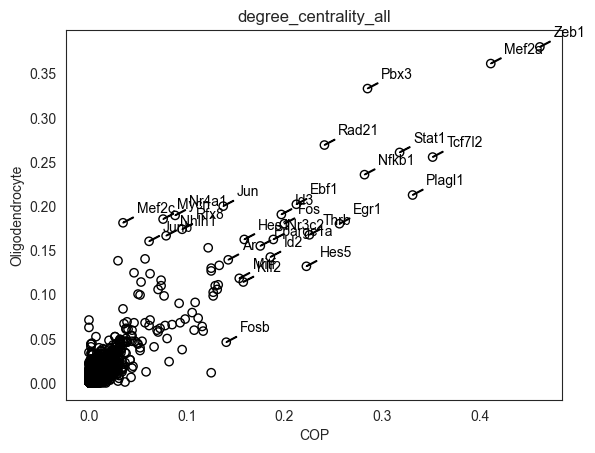

In [29]:
metrices = "degree_centrality_all"
links.plot_score_comparison_2D(value=metrices,
                               cluster1="COP", cluster2="Oligodendrocyte",
                               percentile=98,
                               save=f"../plot/{metrices}_score_comparison")

#### 3. In silico perturbation (RESTART from here)
- based on pySCENIC preliminary results

In [ ]:
# # RELOAD when kernel die
# oracle = co.load_hdf5(os.path.join(data_path, 'obj.celloracle.oracle'))
# links = co.load_hdf5(os.path.join(data_path, 'links.celloracle.links'))
# adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))

In [ ]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [ ]:
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

In [ ]:
# Up : # Klf12, Zeb1, Usf2, Pknox2
# Down : #Mxd4, #Msx2, Nkx6-2, #Nfe2l3, #Zbtb7b

In [ ]:
goi = "Pknox2"
print(goi in oracle.adata.var_names)

In [ ]:
sc.pl.umap(oracle.adata, color = [goi, oracle.cluster_column_name], layer = 'imputed_count', legend_loc = 'on data')

In [ ]:
oracle.simulate_shift(perturb_condition={goi:0.0}, n_propagation=3)
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1)
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 40
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

In [ ]:
oracle.suggest_mass_thresholds(n_suggestion=12)

In [ ]:
min_mass = 17
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 25
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
oracle.adata.obs['Pseudotime'] = pt.adata.obs.Pseudotime
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass)
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

In [ ]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

In [ ]:
# Visualize results
fig, ax = plt.subplots(figsize=[8, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [ ]:
# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

In [ ]:
vm = 0.5 # adjust

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

In [ ]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[8, 6])
plt.title(f'{goi} Perturbation Simulation')
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

#### 4. In silico perturbation in tumors

In [ ]:
cell_idx = np.where(oracle.adata.obs[oracle.cluster_column_name].isin(lineage_dictionary["Tumor"]))[0]


In [ ]:
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle,
                                 cell_idx_use=cell_idx, # Enter cell id list
                                 name="Idh1 mutant glioma" # Name of this cell group. You can enter any name.
                                 )

# Calculation
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

In [ ]:
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=vm)


In [ ]:
# Compare
sc.pl.umap(adata, color = ['cell_type'], legend_loc = 'on data', frameon= False, title = "Cellular Landscape of Idh1-mutant glioma")

In [ ]:
oracle.to_hdf5(file_path=os.path.join(data_path, 'fin_object.celloracle.oracle'))